In [30]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

full_amp_img = np.load('../../../CCD_analysis/output_140804/3meanmap075.npy')
print full_amp_img.shape

(1922, 442)


In [31]:
def runTestAna(small_img):
    data_like_source = Source(num_x=small_img.shape[1]+1,num_y=small_img.shape[0]+1) 
    data_like_source.fluxes += 1 #fit to flat field
    small_img = small_img.transpose()
    data_mg = FlatFitter(data_like_source,small_img)
    data_mg.fit(maxiter=10000,verbose=False, step_size=1e-2,learning_rate_decay=1e-5)

    data_mg.source.plot(small_img, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data')
    data_mg.source.plot(small_img - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
    plt.title('Data-Model')
    plt.figure()
    plt.title('Image Histograms')
    _ = plt.hist([small_img.flatten(), data_mg.source.fluxes.flatten()],
                 bins=50, histtype='step',label=['Data','Model'])
    plt.legend()
    plt.figure()
    plt.title('Residuals')
    _ = plt.hist((data_mg.source.fluxes - small_img).flatten(),bins=50)

0.00388977470548


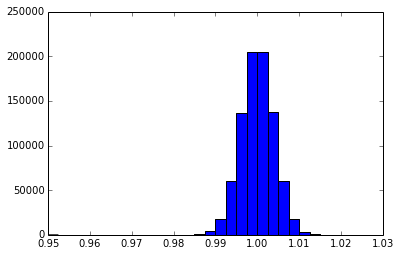

In [32]:
fitted = ws.data_tools.fitIlluminationVariation(full_amp_img)
data_rel_flux_map = (full_amp_img-fitted)/fitted+1
_ =plt.hist(data_rel_flux_map.flatten(),bins=40,range=(.95,1.05))
sigma = np.std(data_rel_flux_map)
print sigma

In [33]:
small_img = data_rel_flux_map[1500:1700,150:350]
mask = np.logical_not(np.logical_and(small_img < np.mean(small_img)+5*sigma,small_img > np.mean(small_img)-5*sigma))
locs = np.where(mask)
print locs
#plt.scatter(locs[0],locs[1])

(array([31, 31, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 45, 46, 46, 47]), array([161, 162, 161, 162, 163, 161, 162, 163, 164, 161, 162, 163, 147,
       146, 147, 147]))


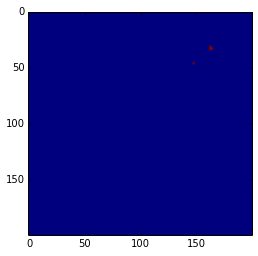

In [34]:
plt.imshow(mask,interpolation=None)

maxiter reached


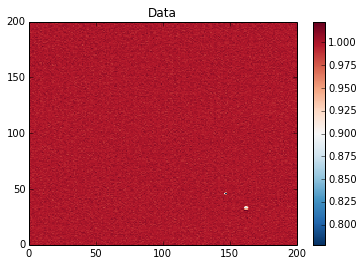

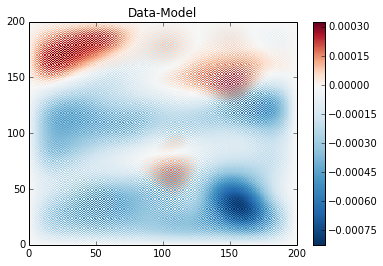

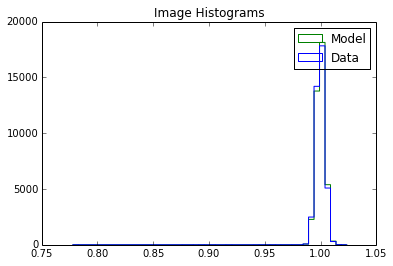

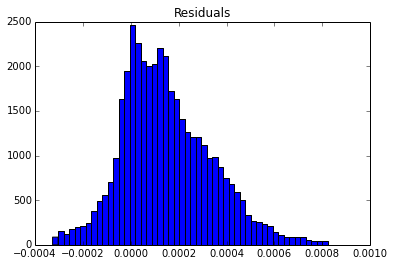

In [35]:
runTestAna(small_img)

Seems like bad pixels might not be such a big deal?

##Fill bad pixels with medians of 8-neighbors

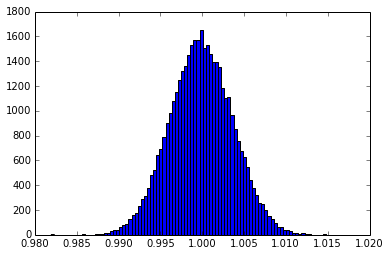

In [37]:
small_img[mask] = 1
_ = plt.hist(small_img.flatten(), bins=100)

maxiter reached


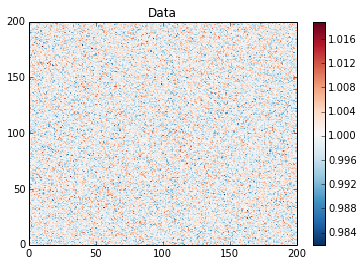

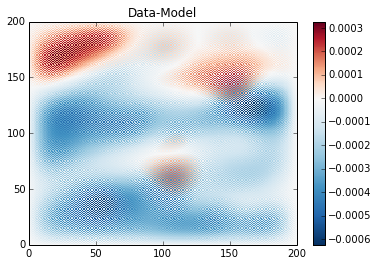

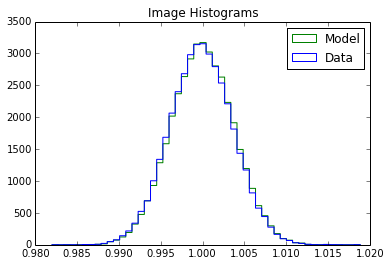

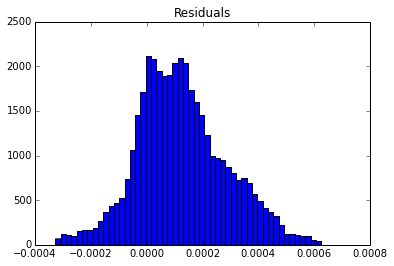

In [38]:
runTestAna(small_img)

So it seems by setting all bad pixels to one, the residuals are slightly better, but they weren't all that bad to begin with. Effects will be more clear on DES...